# Part 1 : Face detection from training images.

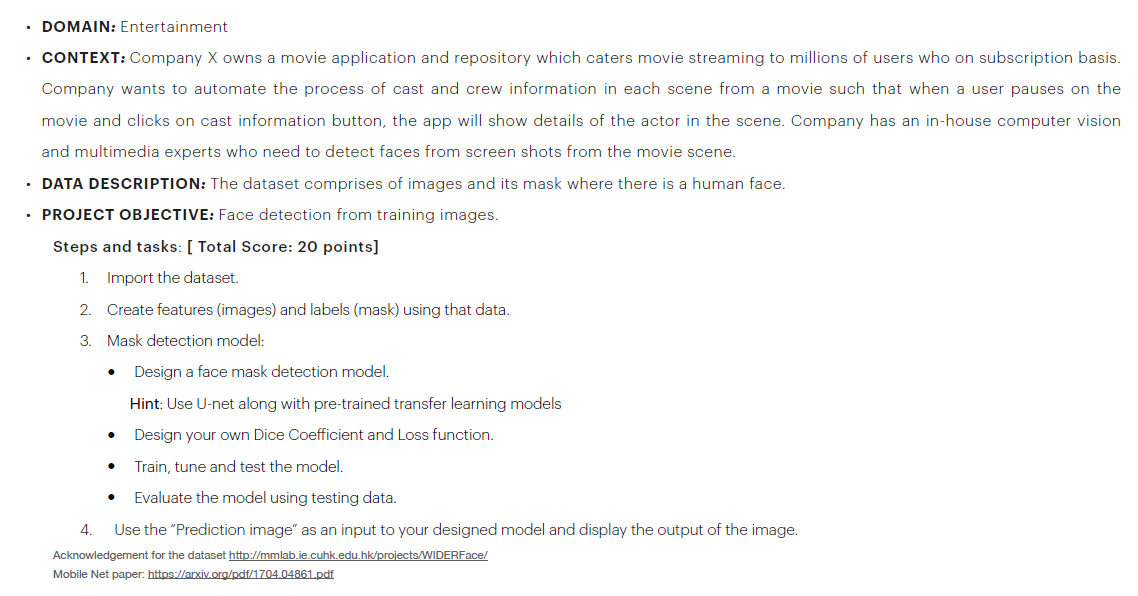

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
os.chdir('/content/drive/MyDrive/Colab Notebooks')

**Loading the Dataset**

In [3]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.7.0'

In [4]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray

In [7]:
# Loading the images file

data = np.load('Dataset- Images.npy', allow_pickle=True)

In [ ]:
data.shape

(409, 2)

The file contains 409 images and labels. 

In [9]:
data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [11]:
data[400][1]

[{'imageHeight': 1357,
  'imageWidth': 1357,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.35969664138678226, 'y': 0.23835319609967498},
   {'x': 0.600216684723727, 'y': 0.4788732394366197}]},
 {'imageHeight': 1357,
  'imageWidth': 1357,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.11700975081256772, 'y': 0.38894907908992415},
   {'x': 0.3131094257854821, 'y': 0.5969664138678223}]},
 {'imageHeight': 1357,
  'imageWidth': 1357,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.5319609967497292, 'y': 0.6164680390032503},
   {'x': 0.7313109425785482, 'y': 0.8548212351029253}]}]

**Viewing few random images and labels in the dataset**

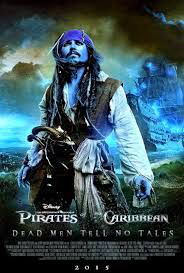

In [17]:
from google.colab.patches import cv2_imshow

cv2_imshow(data[147][0])

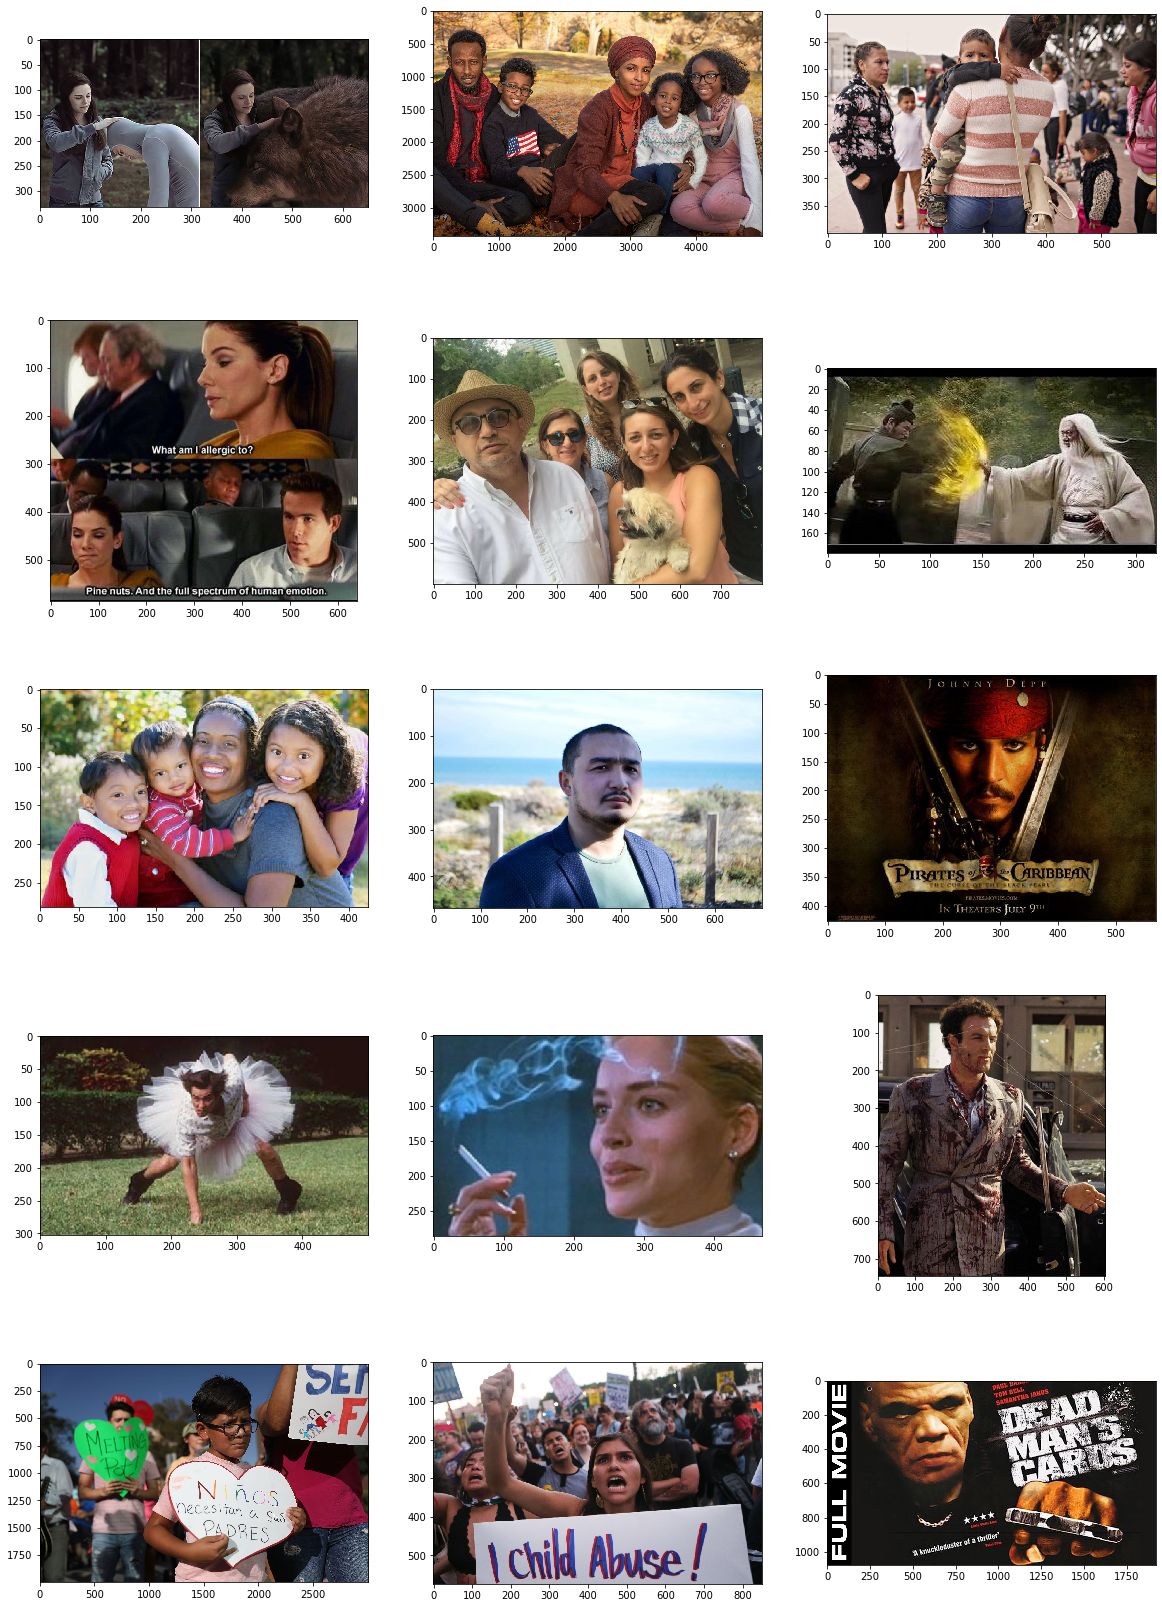

In [20]:
fi,ax = plt.subplots(5,3,figsize=(20,30))
row = 0
col = 0
index = 0
for i in range(15):
  ax[row][col].imshow(data[index][0], interpolation='nearest')
  index = index + 12
  col = col + 1
  if col > 2:
    row = row + 1
    col = 0
plt.show()


**Creating features (images) and labels (mask)**

In [21]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  # assign all pixels in the first 3 channels only to the image, i.e., discard the alpha channel
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    # convert the grayscale image to color so that the number of channels are standardized to 3
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")


Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


**Splitting the data into train and test sets**

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


**Visualizing X_train and y_train images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


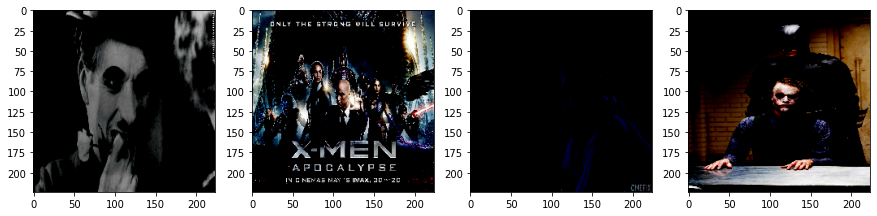

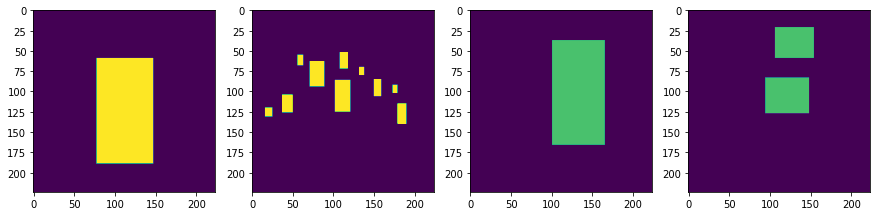

In [23]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

**Creating a Mask Detection Model using U-net with MobileNet Transfer Learning Model**

In [24]:
IMAGE_SIZE = 224
EPOCHS = 30
BATCH = 8
LR = 1e-4

In [25]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [26]:
model = model()
model.summary()

2031616/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                               

**Designing Dice Coefficient and Loss function**

In [27]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

**Compile the Model**

In [29]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [30]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

**Training the Model**

In [31]:
train_steps = len(X_train)//BATCH
valid_steps = len(X_val)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_val) % BATCH != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
41/41 [==============================] - 59s 309ms/step - loss: 0.7422 - dice_coef: 0.2578 - recall_1: 0.9683 - precision_1: 0.1487 - val_loss: 0.7415 - val_dice_coef: 0.2410 - val_recall_1: 1.0000 - val_precision_1: 0.1353 - lr: 1.0000e-04
Epoch 2/30
41/41 [==============================] - 9s 218ms/step - loss: 0.6714 - dice_coef: 0.3284 - recall_1: 0.9483 - precision_1: 0.2672 - val_loss: 0.7093 - val_dice_coef: 0.2710 - val_recall_1: 0.9969 - val_precision_1: 0.1609 - lr: 1.0000e-04
Epoch 3/30
41/41 [==============================] - 9s 218ms/step - loss: 0.6503 - dice_coef: 0.3495 - recall_1: 0.9384 - precision_1: 0.3727 - val_loss: 0.6965 - val_dice_coef: 0.2827 - val_recall_1: 0.9935 - val_precision_1: 0.1913 - lr: 1.0000e-04
Epoch 4/30
41/41 [==============================] - 9s 224ms/step - loss: 0.6392 - dice_coef: 0.3610 - recall_1: 0.9433 - precision_1: 0.4197 - val_loss: 0.6706 - val_dice_coef: 0.3067 - val_recall_1: 0.9843 - val_precision_1: 0.2363 - lr: 1.0000

**Evaluating the Model**

In [33]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

3/3 [==============================] - 0s 61ms/step - loss: 0.5775 - dice_coef: 0.4190 - recall_1: 0.7647 - precision_1: 0.6449


[0.5774901509284973,
 0.4189836084842682,
 0.7646750211715698,
 0.6449441313743591]

The model has precision and recall of 64.5% and 76.47% respectively. The loss is 57.75% and dice coefficient is 41.9%. 

**Predicting an image that was not used for training and testing the model**

In [36]:
filename = './Prediction_Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [37]:
feat_scaled

array([[[ 0.5686275 ,  0.4666667 ,  0.45098042],
        [ 0.56078434,  0.45882356,  0.4431373 ],
        [ 0.5764706 ,  0.47450984,  0.45882356],
        ...,
        [-0.17647058, -0.5058824 , -0.73333335],
        [-0.27058822, -0.49019605, -0.75686276],
        [-0.27843136, -0.47450978, -0.7411765 ]],

       [[ 0.6       ,  0.49803925,  0.48235297],
        [ 0.6       ,  0.4901961 ,  0.48235297],
        [ 0.6313726 ,  0.5294118 ,  0.5137255 ],
        ...,
        [-0.20784312, -0.52156866, -0.7490196 ],
        [-0.16862744, -0.40392154, -0.6627451 ],
        [-0.19215685, -0.41176468, -0.6784314 ]],

       [[ 0.54509807,  0.45098042,  0.41960788],
        [ 0.47450984,  0.3803922 ,  0.34901965],
        [ 0.5372549 ,  0.4431373 ,  0.4039216 ],
        ...,
        [-0.14509803, -0.42745095, -0.6627451 ],
        [-0.3098039 , -0.5686275 , -0.827451  ],
        [-0.34117645, -0.5921569 , -0.8509804 ]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1

In [38]:
y_pred = model.predict(np.array([feat_scaled]))
y_pred

array([[[[0.48006684],
         [0.3889131 ],
         [0.3746988 ],
         ...,
         [0.39864415],
         [0.4323301 ],
         [0.4317319 ]],

        [[0.27318296],
         [0.13090998],
         [0.1408385 ],
         ...,
         [0.22008799],
         [0.25732112],
         [0.3003517 ]],

        [[0.26447248],
         [0.16960235],
         [0.15262362],
         ...,
         [0.20325431],
         [0.24522787],
         [0.27950525]],

        ...,

        [[0.2721034 ],
         [0.16779904],
         [0.17811865],
         ...,
         [0.21163788],
         [0.22980098],
         [0.30001134]],

        [[0.28707376],
         [0.17931996],
         [0.21992265],
         ...,
         [0.23341545],
         [0.2616691 ],
         [0.30361667]],

        [[0.30872422],
         [0.20021217],
         [0.21333845],
         ...,
         [0.22677626],
         [0.2528228 ],
         [0.34401765]]]], dtype=float32)

In [39]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))

**Viewing the predicted image and its face-detected output**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


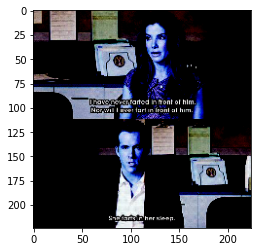

In [40]:
plt.imshow(feat_scaled)

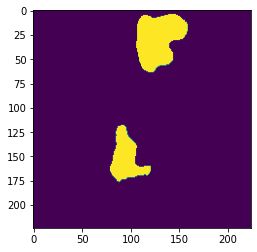

In [41]:
plt.imshow(pred_mask)

The model was able to detect two faces in the image correctly.


# Part 2: Help to create an image dataset to be used by the AI team to build an image classifier data. Profile images of people are given

**• DOMAIN:**
> Entertainment


**• CONTEXT:**
> Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

**• TASK:**
> Help to create an image dataset to be used by the AI team to build an image classifier data. Profile images of people are given.

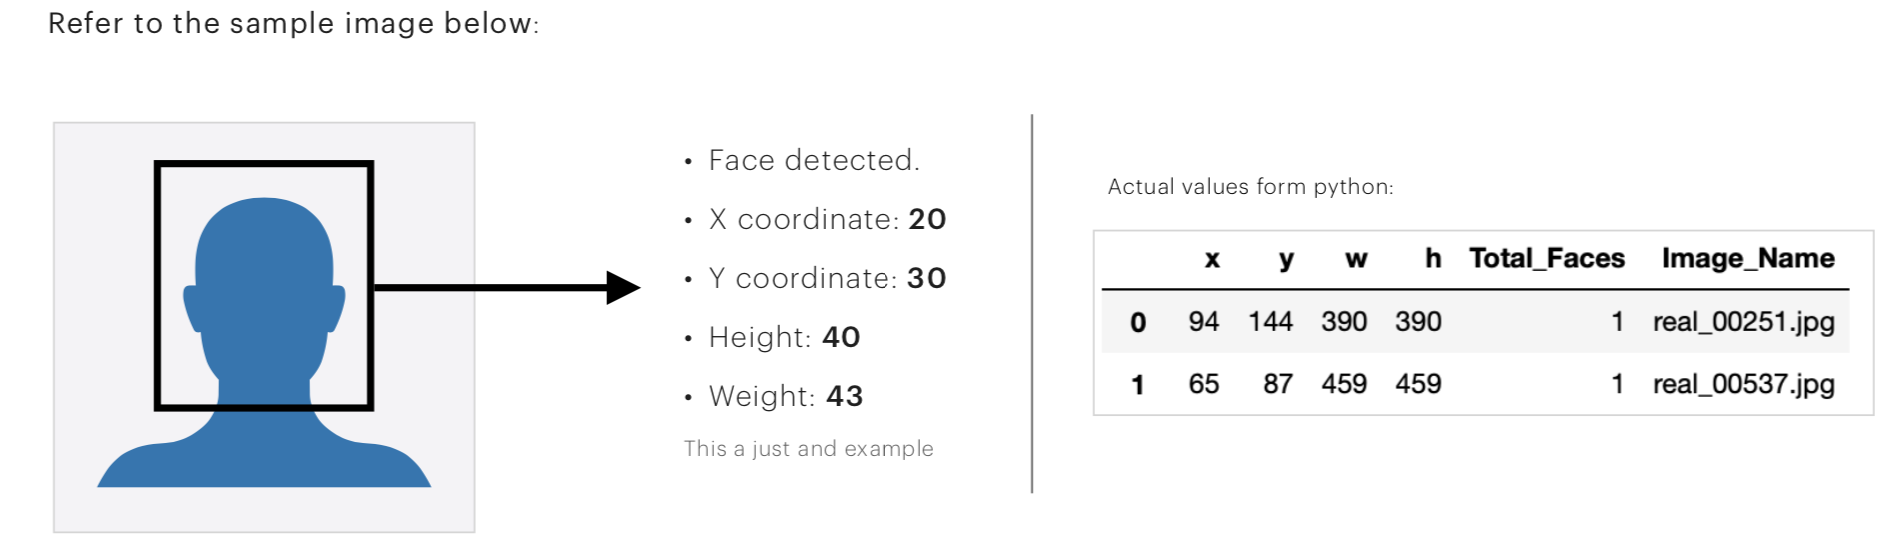

**Importing the Libraries**

In [42]:
from tqdm.notebook import trange, tqdm
from IPython.display import Image, display, Markdown, clear_output
from zipfile import ZipFile

In [43]:
project_path = '/content/drive/MyDrive/Colab Notebooks/'
image_files = 'Part 2 - training images.zip'

**Unzipping the zipped file**

In [44]:
images_zip_path = os.path.join(project_path, image_files)

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

**Getting the unzipped location**

In [45]:
## Get the Unzipped Location in the drive

zip_dir_loc = z.filelist[0].filename.split("/")[0] 
zip_dir_loc

'training_images'

**Viewing the names of the images**

In [46]:
raw_img_file_names = [os.path.join(zip_dir_loc,i) for i in os.listdir(zip_dir_loc)]
raw_img_file_names[:5]

['training_images/real_00963.jpg',
 'training_images/real_01015.jpg',
 'training_images/real_01053.jpg',
 'training_images/real_00946.jpg',
 'training_images/real_01006.jpg']

**Reading the images**

In [47]:
img_list = []
for imgs in tqdm(raw_img_file_names):
  tst_img = cv2.imread(imgs)
  img_list.append(tst_img)
img_list = np.array(img_list)
display(Markdown(f"#### {img_list.shape}"))

  0%|          | 0/1091 [00:00<?, ?it/s]

#### (1091, 600, 600, 3)

There are 1091 images with 600 X 600 dimensions, and 3 channels (RGB) which means that the images are colored and not grayscale.

**Viewing random images**

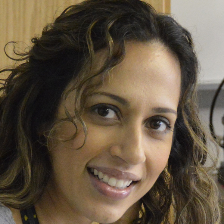

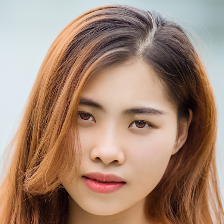

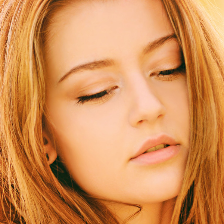

In [53]:
from google.colab.patches import cv2_imshow

for i in img_list[15:18,]:
  cv2_imshow(cv2.resize(i,(224,224)))

**Defining a function to create bounding boxes**

In [54]:
def test_bb(df,fname,title=""):

  tst_img = cv2.imread(fname)
  temp_df = df[df['Image_Name'] == fname]
  rect_img = []
  for rows in temp_df.index:
    x = df['x'][rows]
    y = df['y'][rows]
    w = df['w'][rows]
    h = df['h'][rows]
    cv2.rectangle(tst_img,(x,y),(x+w,y+h),(255,0,0),2)
    cv2.putText(tst_img, title, (int((x+w)*0.75),y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
  cv2_imshow(tst_img)
  
  return

**Defining a function to read images and resize them**

In [55]:
def show_face(img_list,scale=1.0):

  for imgs in img_list:
    img = cv2.imread(imgs)
    img_w  = int(img.shape[1]*scale)
    img_h = int(img.shape[0]*scale)
    img = cv2.resize(img,(img_w,img_h))
    display(Markdown(f"#### {imgs}"))
    cv2_imshow(img)

  return

**Downloading the HAAR Model**

In [56]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2021-11-12 22:56:48--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.1s    

2021-11-12 22:56:49 (8.94 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [57]:
haar_img_box_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])
haar_img_box_df

Empty DataFrame
Columns: [x, y, w, h, Total_Faces, Image_Name]
Index: []

**Detecting Faces using HAAR Model**

### Bounding Box parameters are `x`:114, `y`:49, `width`:462, `height`:462

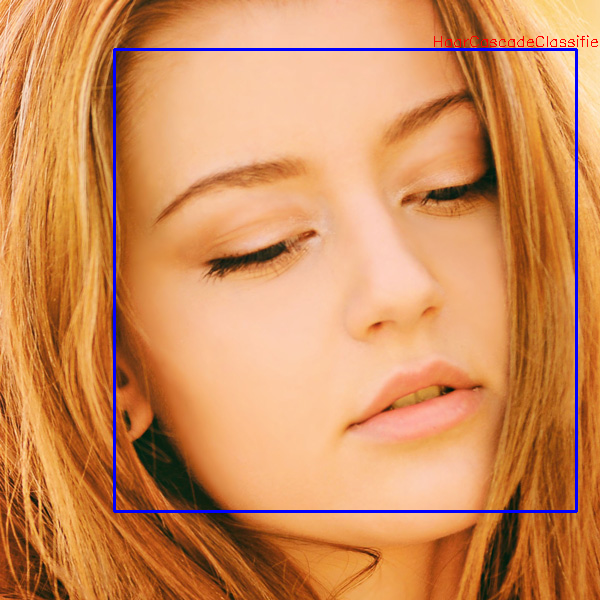

In [59]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

test_img = cv2.imread(raw_img_file_names[17])
grey = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(grey,1.1,4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
  cv2.rectangle(test_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
  cv2.putText(test_img, "HaarCascadeClassifier", (int((x+w)*0.75),y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))

# Display the output
display(Markdown(f"### Bounding Box parameters are `x`:{x}, `y`:{y}, `width`:{w}, `height`:{h}"))
cv2_imshow(test_img)

**Detecting faces for all the images**

In [60]:
%%time
haar_undetected_images = []
haar_detected_images = []

for imgs, fnames in tqdm(zip(img_list,raw_img_file_names)):
  gray = cv2.cvtColor(imgs,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,1.1,4)
  if len(faces) == 0:
    haar_undetected_images.append(fnames)
    temp_dict = {'x':0, 
                 'y':0, 
                 'w':-1,
                 'h':-1, 
                 'Total_Faces':0,
                 'Image_Name':fnames} 
  else:
    haar_detected_images.append(fnames)
    for (x,y,w,h) in faces:
      temp_dict = {'x':x, 
                  'y':y, 
                  'w':w,
                  'h':h, 
                  'Total_Faces':len(faces),
                  'Image_Name':fnames} 
      haar_img_box_df = haar_img_box_df.append(temp_dict,ignore_index=True)
display(Markdown(f"#### Detected faces for {len(haar_detected_images)} images"))
display(Markdown(f"#### Failed to detect faces for {len(haar_undetected_images)} images"))

0it [00:00, ?it/s]

#### Detected faces for 930 images

#### Failed to detect faces for 161 images

CPU times: user 6min 41s, sys: 0 ns, total: 6min 41s
Wall time: 3min 38s


In [62]:
haar_img_box_df

x    y    w    h Total_Faces                      Image_Name
0     202  176  324  324           1  training_images/real_00963.jpg
1      78   96  444  444           1  training_images/real_01015.jpg
2      68   50  471  471           1  training_images/real_01053.jpg
3      53  120  431  431           1  training_images/real_01006.jpg
4      47   72  462  462           1  training_images/real_00974.jpg
...   ...  ...  ...  ...         ...                             ...
1006  102  185  405  405           1  training_images/real_00089.jpg
1007  222  204  279  279           1  training_images/real_00036.jpg
1008   91   28   90   90           3  training_images/real_00004.jpg
1009   13   12  162  162           3  training_images/real_00004.jpg
1010  134  173  356  356           3  training_images/real_00004.jpg

[1011 rows x 6 columns]

Out of a total of 1091 images, the HAAR was able to detect only 1011 images with one or more faces correctly.

In [63]:
haar_img_box_df[haar_img_box_df['Total_Faces'] > 1]

x    y    w    h Total_Faces                      Image_Name
25     41  213   50   50           2  training_images/real_00949.jpg
26    354  295   60   60           2  training_images/real_00949.jpg
27    276  110   64   64           3  training_images/real_00980.jpg
28    108  181   26   26           3  training_images/real_00980.jpg
29     22  504   75   75           3  training_images/real_00980.jpg
...   ...  ...  ...  ...         ...                             ...
1004  461   54  100  100           2  training_images/real_00358.jpg
1005  126  163  418  418           2  training_images/real_00358.jpg
1008   91   28   90   90           3  training_images/real_00004.jpg
1009   13   12  162  162           3  training_images/real_00004.jpg
1010  134  173  356  356           3  training_images/real_00004.jpg

[156 rows x 6 columns]

There are 156 images which have more than one face.

**Viewing samples of correctly and incorrectly detected faces using the HAAR Model**

### (1) Correctly detected 1 face

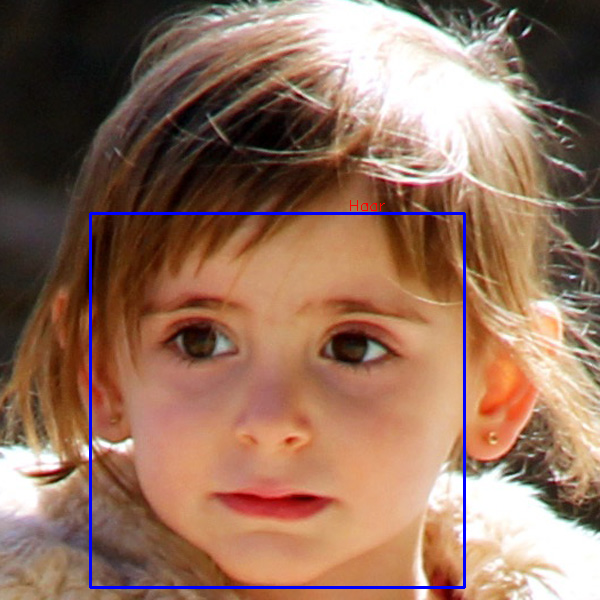

### (2) Incorrectly detected multiple faces

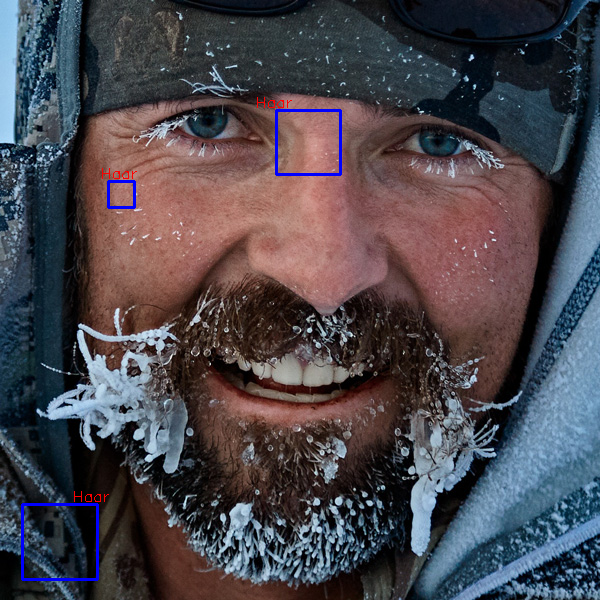

In [70]:
display(Markdown("### (1) Correctly detected 1 face"))
test_bb(haar_img_box_df,"training_images/real_00312.jpg",title="Haar")
display(Markdown("### (2) Incorrectly detected multiple faces"))
test_bb(haar_img_box_df,"training_images/real_00980.jpg",title="Haar")

**Incorrectly detected faces using the HAAR Model**

#### training_images/real_00007.jpg

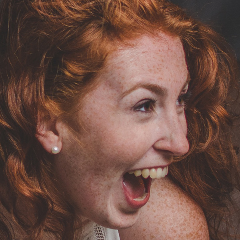

#### training_images/real_00016.jpg

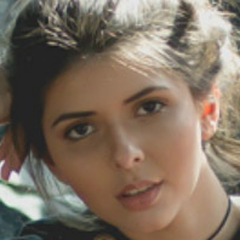

#### training_images/real_00020.jpg

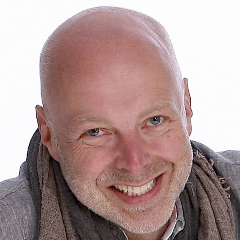

#### training_images/real_00341.jpg

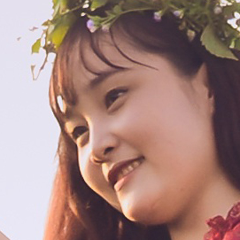

#### training_images/real_00009.jpg

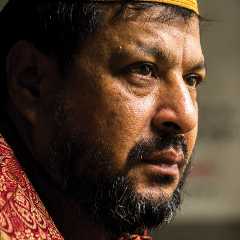

In [71]:
show_face(haar_undetected_images[-5:],scale=0.4)

**Downloading the MTCNN model to detect faces**

In [72]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 2.3 MB/s 


In [73]:
from mtcnn.mtcnn import MTCNN
mtcnn_det = MTCNN()

**Detecting faces using the MTCNN Model**

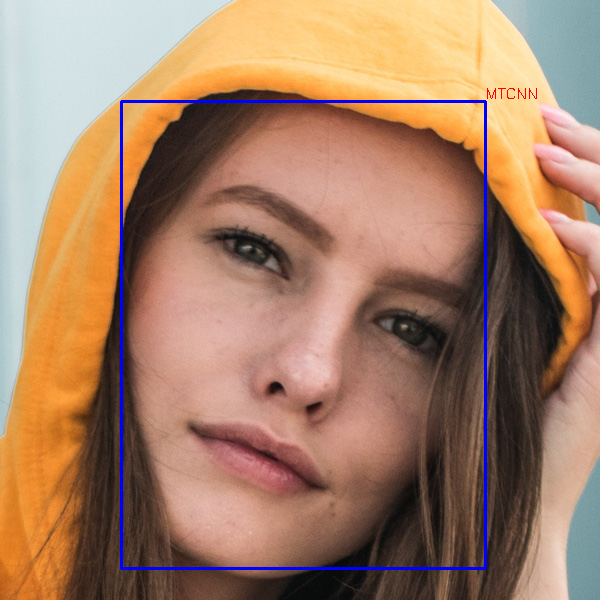

In [80]:
mtcnn_tst_img = cv2.imread(raw_img_file_names[80])
mt_cvt = cv2.cvtColor(mtcnn_tst_img,cv2.COLOR_BGR2RGB)
mt_faces = mtcnn_det.detect_faces(mt_cvt)
for face in mt_faces:
  mt_x, mt_y,mt_w,mt_h = face['box']
  cv2.rectangle(mtcnn_tst_img,(mt_x,mt_y),(mt_x + mt_w,mt_y + mt_h),(255,0,0),2)
  cv2.putText(mtcnn_tst_img, "MTCNN", (int((mt_x+mt_w)*1),mt_y-3),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255))
cv2_imshow(mtcnn_tst_img)

In [81]:
mtcnn_img_box_df = pd.DataFrame(columns=['x','y','w','h','Total_Faces','Image_Name'])
mtcnn_img_box_df

Empty DataFrame
Columns: [x, y, w, h, Total_Faces, Image_Name]
Index: []

In [82]:
%%time
mtcnn_undetected_images = []
mtcnn_detected_images = []
for imgs, fnames in tqdm(zip(img_list,raw_img_file_names)):
  cvt_img = cv2.cvtColor(imgs,cv2.COLOR_BGR2RGB)
  faces = mtcnn_det.detect_faces(cvt_img)
  if len(faces) == 0:
    mtcnn_undetected_images.append(fnames)
    temp_dict = {'x':0, 
                 'y':0, 
                 'w':-1,
                 'h':-1, 
                 'Total_Faces':0,
                 'Image_Name':fnames} 
  else:
    mtcnn_detected_images.append(fnames)
    for face in faces:
      temp_dict = {'x':face['box'][0], 
                  'y':face['box'][1], 
                  'w':face['box'][2],
                  'h':face['box'][3], 
                  'Total_Faces':len(faces),
                  'Image_Name':fnames} 
      mtcnn_img_box_df = mtcnn_img_box_df.append(temp_dict,ignore_index=True)

display(Markdown(f"#### Detected faces for {len(mtcnn_detected_images)} images"))
display(Markdown(f"#### Failed to detect faces for {len(mtcnn_undetected_images)} images"))

0it [00:00, ?it/s]

#### Detected faces for 1086 images

#### Failed to detect faces for 5 images

CPU times: user 14min 25s, sys: 40.4 s, total: 15min 5s
Wall time: 15min 9s


In [83]:
mtcnn_img_box_df

x    y    w    h Total_Faces                      Image_Name
0     203  134  256  411           1  training_images/real_00963.jpg
1     119   67  423  516           1  training_images/real_01015.jpg
2      52   41  445  526           1  training_images/real_01053.jpg
3     142  123  418  401           1  training_images/real_00946.jpg
4     109   79  366  487           2  training_images/real_01006.jpg
...   ...  ...  ...  ...         ...                             ...
1098  123  144  361  452           1  training_images/real_00089.jpg
1099  163  150  272  409           1  training_images/real_00036.jpg
1100  133  121  319  417           2  training_images/real_00004.jpg
1101  552  337   24   29           2  training_images/real_00004.jpg
1102  146    0  365  547           1  training_images/real_00009.jpg

[1103 rows x 6 columns]

In [84]:
display(mtcnn_img_box_df[mtcnn_img_box_df['Total_Faces'] > 1])
display(Markdown(f"#### Number of images with more than 1 face detected : {len(mtcnn_img_box_df[mtcnn_img_box_df['Total_Faces'] > 1])}"))

x    y    w    h Total_Faces                      Image_Name
4     109   79  366  487           2  training_images/real_01006.jpg
5     461  187   40   51           2  training_images/real_01006.jpg
9     112   73  385  492           2  training_images/real_01058.jpg
10    193    0   68   74           2  training_images/real_01058.jpg
74    170  184  321  426           2  training_images/real_00950.jpg
75    117   28   51   60           2  training_images/real_00950.jpg
135    69   26  472  597           2  training_images/real_01004.jpg
136   539  231   28   36           2  training_images/real_01004.jpg
178   142  115  351  476           2  training_images/real_01054.jpg
179   429   14  181  197           2  training_images/real_01054.jpg
253    56   72  429  491           2  training_images/real_00788.jpg
254   374    1   55   65           2  training_images/real_00788.jpg
346   139  148  317  433           2  training_images/real_00699.jpg
347    50  472   64   78           2  training_images/real_00699.jpg
419   175  130  309  441           2  training_images/real_00590.jpg
420   463  193   65   77           2  training_images/real_00590.jpg
422   151  149  387  449           2  training_images/real_00666.jpg
423   106  379   58   75           2  training_images/real_00666.jpg
482   145  130  329  430           2  training_images/real_00591.jpg
483    45  112   21   28           2  training_images/real_00591.jpg
799   147  152  296  390           2  training_images/real_00191.jpg
800   133  180   22   22           2  training_images/real_00191.jpg
802    95   91  366  432           2  training_images/real_00178.jpg
803    25  224   57   75           2  training_images/real_00178.jpg
810   119  158  317  429           2  training_images/real_00274.jpg
811   190   10  240  261           2  training_images/real_00274.jpg
831    93  134  348  393           2  training_images/real_00259.jpg
832   194  185  310  391           2  training_images/real_00259.jpg
849   103   65  361  491           2  training_images/real_00241.jpg
850    29  492   46   71           2  training_images/real_00241.jpg
882   101   64  368  484           2  training_images/real_00201.jpg
883   473  257   56   75           2  training_images/real_00201.jpg
1100  133  121  319  417           2  training_images/real_00004.jpg
1101  552  337   24   29           2  training_images/real_00004.jpg

#### Number of images with more than 1 face detected : 34

**Viewing samples of correctly and incorrectly detected faces using the MTCNN model**

### (1) Correctly detected 1 face

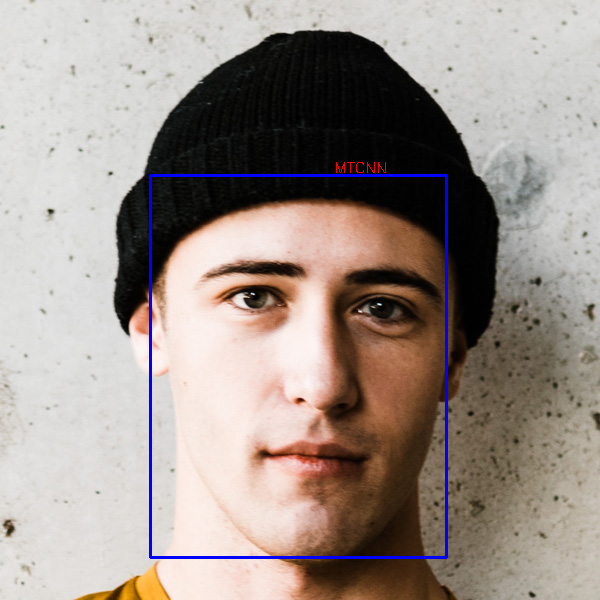

### (2) Correctly detected one face and incorrectly the other one

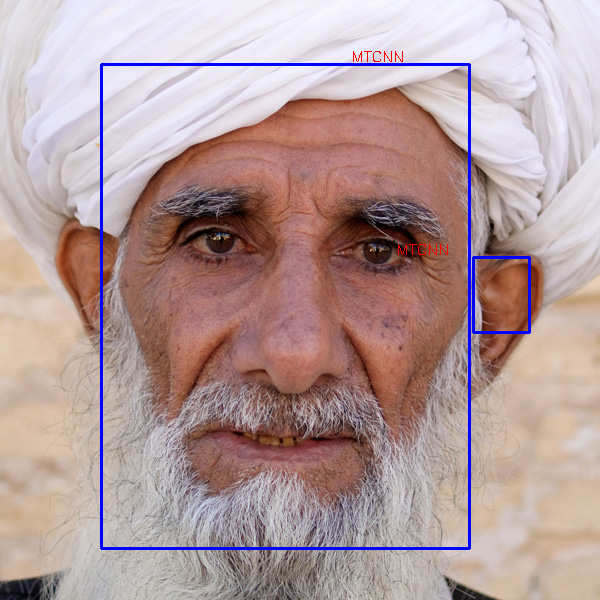

In [89]:
display(Markdown("### (1) Correctly detected 1 face"))
test_bb(mtcnn_img_box_df,"training_images/real_00116.jpg",title="MTCNN")
display(Markdown("### (2) Correctly detected one face and incorrectly the other one"))
test_bb(mtcnn_img_box_df,"training_images/real_00201.jpg",title="MTCNN")

**Incorrectly detected faces using the MTCNN Model**

#### training_images/real_00951.jpg

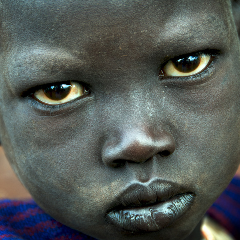

#### training_images/real_00818.jpg

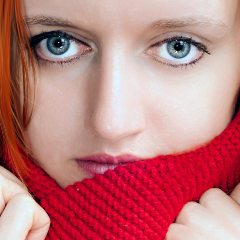

#### training_images/real_00692.jpg

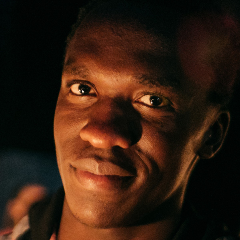

#### training_images/real_00696.jpg

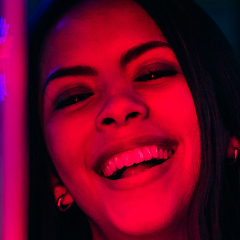

#### training_images/real_00672.jpg

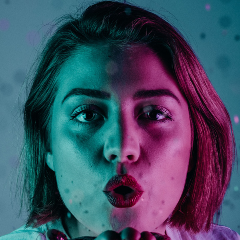

In [90]:
show_face(mtcnn_undetected_images,scale=0.4)

**Observation:**

There are about 5 images where a face could not be detected due to:
  - Face partailly covered
  - Face zoomed such that it crops part of the face
  - Poor illumination or partially lit surfaces on the face

The MTCNN has detected face in images where,
  - Tilted face
  - Side face

**Displaying all the faces that were not detected by either HAAR or MTCNN Model**

#### training_images/real_00951.jpg

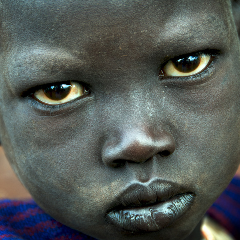

#### training_images/real_00818.jpg

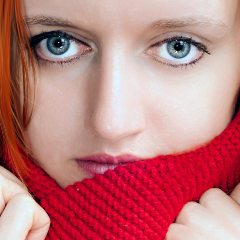

#### training_images/real_00692.jpg

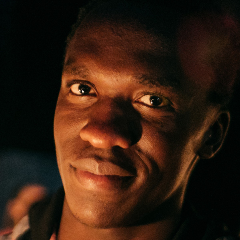

In [91]:
haar_set = set(haar_undetected_images)
mtcnn_set = set(mtcnn_undetected_images)
show_face(haar_set.intersection(mtcnn_set),0.4)

**Observation:**


- MTCNN model did a better job by detecting mostly all faces except for 5 images  when compared performance-wise.
- MTCNN is time consuming compared to HAAR model. This model cannot be used for real-time applications where faces need to be detected fast.